In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import accuracy_score,classification_report,recall_score


import seaborn as sns
import matplotlib.pyplot as plt
from models.Knn_custom import KNN 
from models.Kmeans import K_Means

from models.Dbscan import DBSCAN_custom
from models.dt import DecisionTree
from models.RF import RandomForest 
from models.Metrics import *

from time import time

Load Data

In [33]:
data1 = pd.read_csv("data/Dataset1.csv")

In [34]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   N          885 non-null    int64  
 1   P          885 non-null    object 
 2   K          885 non-null    int64  
 3   pH         885 non-null    float64
 4   EC         885 non-null    float64
 5   OC         884 non-null    float64
 6   S          885 non-null    float64
 7   Zn         885 non-null    float64
 8   Fe         885 non-null    float64
 9   Cu         884 non-null    float64
 10  Mn         885 non-null    float64
 11  B          885 non-null    float64
 12  OM         885 non-null    float64
 13  Fertility  885 non-null    int64  
dtypes: float64(10), int64(3), object(1)
memory usage: 96.9+ KB


In [35]:
data1.head()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,OM,Fertility
0,138,8.6,560,7.46,0.62,0.70,5.9,0.24,0.31,0.77,8.71,0.11,1.2040,0
1,213,7.5,338,7.62,0.75,1.06,25.4,0.30,0.86,1.54,2.89,2.29,1.8232,0
2,163,9.6,718,7.59,0.51,1.11,14.3,0.30,0.86,1.57,2.70,2.03,1.9092,0
3,157,6.8,475,7.64,0.58,0.94,26.0,0.34,0.54,1.53,2.65,1.82,1.6168,0
4,270,9.9,444,7.63,0.40,0.86,11.8,0.25,0.76,1.69,2.43,2.26,1.4792,1


### Preprocessing based on Part1

In [36]:
def process_outliers(data,rep_med=True):
    
    data_copy = data.copy(deep=True)
    
    if not rep_med:
        med = np.nan
    
    for column in data.columns:
        if pd.api.types.is_numeric_dtype(data[column]):
           Q1 = data_copy[column].quantile(0.25)
           Q3 = data_copy[column].quantile(0.75)
           
           if rep_med:
              med = data_copy[column].median()
           
           IQR = Q3 - Q1
           
           max_threshold = Q3 + (IQR*1.5)
           min_threshold = Q1 - (IQR*1.5)
           
           # data_copy[column] = np.where(((data_copy[column]<= max_threshold)&(data_copy[column]>= min_threshold)),data_copy[column],np.nan)
           data_copy[column] = np.where(((data_copy[column]<= max_threshold)&(data_copy[column]>= min_threshold)),data_copy[column],med)
       
    return data_copy    

In [37]:
def preprocess_p2(data,drop_miss=True , outliers=True,replace_median=True,duplicates=True):
    
    data_copy = data.copy(deep=True)
    
    
    data_copy["P"]=pd.to_numeric(data_copy["P"],errors="coerce")
    
    if drop_miss :
       data_copy.dropna(inplace=True)
    else :
        data_copy.fillna(data_copy.median(),inplace=True)
    
    if outliers:
        data_copy = process_outliers(data_copy,rep_med=replace_median)
        data_copy.dropna(inplace=True)
    
    if duplicates:
        data_copy.drop_duplicates(inplace=True)
        # data_copy.drop(columns=["OM","N"],inplace=True)
        # data_copy.drop(columns=["OM"],inplace=True)
        
    data_copy.reset_index(inplace=True,drop=True)    
    
       
    
    return data_copy           
        
        

In [38]:
data1 = preprocess_p2(data1,drop_miss = True , outliers=False,replace_median=True,duplicates=True)

In [39]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   N          878 non-null    int64  
 1   P          878 non-null    float64
 2   K          878 non-null    int64  
 3   pH         878 non-null    float64
 4   EC         878 non-null    float64
 5   OC         878 non-null    float64
 6   S          878 non-null    float64
 7   Zn         878 non-null    float64
 8   Fe         878 non-null    float64
 9   Cu         878 non-null    float64
 10  Mn         878 non-null    float64
 11  B          878 non-null    float64
 12  OM         878 non-null    float64
 13  Fertility  878 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 96.2 KB


In [40]:
data1.describe()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,OM,Fertility
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.00000,878.000000,878.000000,878.000000
mean,246.842825,14.572437,501.042141,7.510706,0.544077,0.617665,7.525239,0.469419,4.145763,0.951697,8.68836,0.586139,1.062384,0.587699
std,77.370500,21.991113,129.100764,0.464720,0.141563,0.843975,4.405285,1.896323,3.107853,0.466295,4.29319,0.564529,1.451637,0.573798
min,6.000000,2.900000,11.000000,0.900000,0.100000,0.100000,0.640000,0.070000,0.210000,0.090000,0.11000,0.060000,0.172000,0.000000
25%,201.000000,6.800000,412.000000,7.350000,0.430000,0.380000,4.700000,0.280000,2.060000,0.630000,6.23000,0.270000,0.653600,0.000000
50%,257.000000,8.100000,475.000000,7.500000,0.550000,0.590000,6.640000,0.360000,3.565000,0.930000,8.36500,0.400000,1.014800,1.000000
75%,307.000000,10.650000,581.000000,7.630000,0.640000,0.780000,8.750000,0.470000,6.320000,1.250000,11.48000,0.610000,1.341600,1.000000
max,383.000000,125.000000,1560.000000,11.150000,0.950000,24.000000,31.000000,42.000000,44.000000,3.020000,31.00000,2.820000,41.280000,2.000000


## Analyse Supervisée

Split Data

In [41]:
X = np.array(data1.drop(columns=['Fertility']))
y = np.array(data1['Fertility']).astype(int)

In [42]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
X = scaler.fit_transform(X)

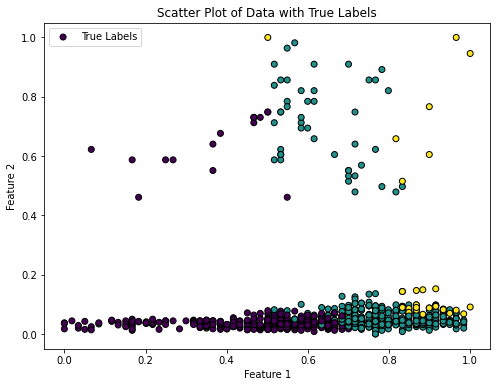

In [43]:
plt.figure(figsize=(8, 6))
# Plot data points with true labels
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', label='True Labels')
plt.title('Scatter Plot of Data with True Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

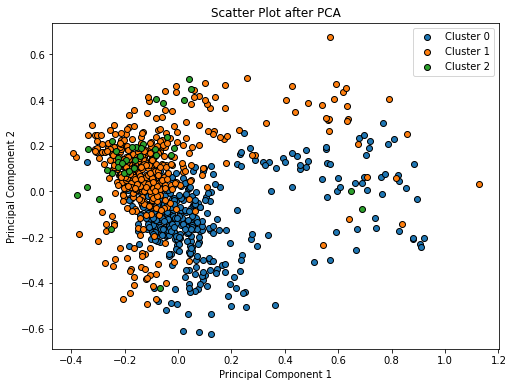

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(8, 6))

for label in np.unique(y):
    indices = y == label
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Cluster {label}', edgecolors='k')

plt.title('Scatter Plot after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [45]:
# df = pd.DataFrame(X, columns=[f'Feature {i+1}' for i in range(X.shape[1])])
# df['Label'] = y

# # Create a pair plot
# sns.pairplot(df, hue='Label', palette='viridis')
# plt.show()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [47]:
def classification_report_custom(y_test,predictions,time):
    knn_eval=[]
    for c in range(3):
        knn_eval.append(["-",precision(y_test,predictions,c),recall(y_test,predictions,c),f1_score(y_test,predictions,c),specificity(y_test,predictions,c),(y_test==c).sum(),"-"])
    
    p,r,f,a,s = calculate_metrics(y_test,predictions)
    
    knn_eval.append([a,p,r,f,s,len(y_test),time])

    return pd.DataFrame(knn_eval,columns=["Accuracy","Precision","Recall","F1-score","Specificity","Support","Time(s)"],index=["0","1","2","global"])

### KNN Custom

In [48]:
knn = KNN(k=9,distance_metric="euclidean")
s=time()
knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_test)
f=time()
time_knn = f-s

In [49]:
classification_report_custom(y_test,predictions_knn,time_knn)

d:\M2\modules\DATA_MINING\projet\datamining\models\Metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positive / (true_positive + false_positive)


,Accuracy,Precision,Recall,F1-score,Specificity,Support,Time(s)
0,-,0.904110,0.825000,0.862745,0.921348,80,-
1,-,0.796117,0.931818,0.858639,0.758621,88,-
2,-,NaN,0.000000,NaN,1.000000,8,-
global,0.840909,0.854167,0.931818,0.891304,0.825000,176,0.602888


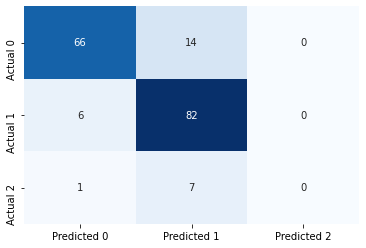

In [50]:
sns.heatmap(confusion_matrix(y_test, predictions_knn), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1",'Predicted 2'],
            yticklabels=["Actual 0", "Actual 1","Actual 2"])
plt.show()

### Decision tree

In [51]:
tree = DecisionTree(max_depth=8)
s=time()
tree.fit(X_train, y_train)
predictions_dt = tree.predict(X_test)
f=time()
time_dt=f-s

In [52]:
classification_report_custom(y_test,predictions_dt,time_dt)

,Accuracy,Precision,Recall,F1-score,Specificity,Support,Time(s)
0,-,0.896104,0.862500,0.878981,0.904762,80,-
1,-,0.824176,0.852273,0.837989,0.813953,88,-
2,-,0.125000,0.125000,0.125000,0.953642,8,-
global,0.818182,0.872093,0.925926,0.898204,0.862500,176,3.016044


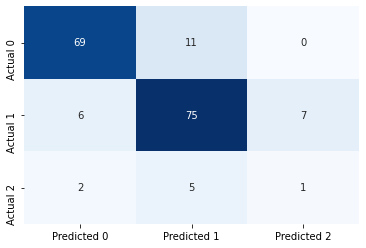

In [53]:
sns.heatmap(confusion_matrix(y_test, predictions_dt), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1",'Predicted 2'],
            yticklabels=["Actual 0", "Actual 1","Actual 2"])
plt.show()

### Decision tree sklearn

### Random Forest

In [54]:
random_forest = RandomForest(n_trees=10, max_depth=5, max_features=None)
s=time()
random_forest.fit(X_train, y_train)
predictions_rf = random_forest.predict(X_test)
f=time()
time_rf=f-s

In [55]:
classification_report_custom(y_test,predictions_rf,time_rf)

d:\M2\modules\DATA_MINING\projet\datamining\models\Metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positive / (true_positive + false_positive)


,Accuracy,Precision,Recall,F1-score,Specificity,Support,Time(s)
0,-,0.914634,0.937500,0.925926,0.922222,80,-
1,-,0.882979,0.943182,0.912088,0.872093,88,-
2,-,NaN,0.000000,NaN,1.000000,8,-
global,0.897727,0.943182,0.943182,0.943182,0.937500,176,23.791994


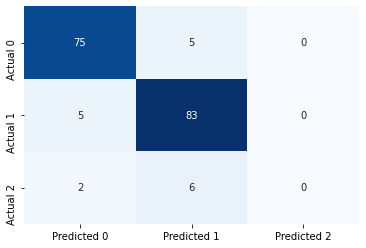

In [56]:
sns.heatmap(confusion_matrix(y_test, predictions_rf), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1",'Predicted 2'],
            yticklabels=["Actual 0", "Actual 1","Actual 2"])
plt.show()

## Analyse Non Supervisée

In [57]:
def clustering_report(data, labels, centroids):
    if len(np.unique(labels)) < 2:
        raise ValueError("Clustering did not form meaningful clusters.")
    metrics = [
        silhouette(data, labels),
        calculate_inter_cluster_distance(data, labels),
        calculate_intra_cluster_distance(data, labels),
        inertia(data, labels, centroids),
        davies_bouldin_index(data, labels, centroids)[0][0]
    ]
    
    # Create a DataFrame with a single row and named columns
    report_df = pd.DataFrame([metrics], columns=["silhouette", "inter_cluster", "intra_cluster", "inertia", "davies"])
    
    return report_df

### Kmeans


sklearn

Custom

In [58]:
kmeans = K_Means(k=9,distance_metric="euclidean")
kmeans.fit(X)

# Get cluster assignments for each data point
labels_kmeans = kmeans.predict(X)

In [59]:
clustering_report(X,labels_kmeans,kmeans.centroids)

,silhouette,inter_cluster,intra_cluster,inertia,davies
0,0.157962,0.48981,0.434576,87.041585,1.620444


## DBSCAN

In [60]:
def get_dbscan_centroids(X, labels):
    unique_labels = np.unique(labels)
    centroids = []

    for label in unique_labels:
        if label == -1:
            # Skip noise points
            continue

        cluster_points = X[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)

    return np.array(centroids)

when you display the clustering report you might encounter an error saying that clustering did not form meanigful clusters 

In [61]:
dbscan = DBSCAN_custom(eps=1.4, min_samples=10)
dbscan.fit(X)

dbscan_centroids = get_dbscan_centroids(X,dbscan.labels)

In [62]:
clustering_report(X,dbscan.labels,dbscan_centroids)

,silhouette,inter_cluster,intra_cluster,inertia,davies
0,0.590017,1.052899,0.621233,2004.495399,1.050576
